In [9]:
import cv2
import numpy as np
import os
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as mp
from keras.models import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten
from keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
import warnings


In [10]:
#warnings.filterwarnings("ignore")
path="Fruit_360"

mylist=os.listdir(path)

classes=len(mylist)

print("Label (Sınıf) Sayısı",classes)




Label (Sınıf) Sayısı 134


In [11]:
images=[]
class_name=[]

for i in range(classes):
    class_fruit=os.listdir(path+"\\"+mylist[i])
    
    for j in class_fruit:
        img=cv2.imread(path+"\\"+mylist[i]+"\\"+j)
        img=cv2.resize(img, (32,32))
        images.append(img)
        class_name.append(mylist[i])
        
print(len(images))
print(len(class_name))         

images=np.array(images)
class_name=np.array(class_name)


90406
90406


In [12]:
#train,test,validation split

x1,x2,y1,y2=train_test_split(images,class_name,test_size=0.5,random_state=42)

x1,x_validation,y1,y_validation=train_test_split(x1,y1,test_size=0.2,random_state=42)

print(f"Resim Sayısı :{images.shape[0]}\nEğitim Verisi Sayısı: {x1.shape[0]}\nTest Verisi Sayısı: {x2.shape[0]}\nDoğrulama Versisi Sayısı:{x_validation.shape[0]}")


Resim Sayısı :90406
Eğitim Verisi Sayısı: 36162
Test Verisi Sayısı: 45203
Doğrulama Versisi Sayısı:9041


In [13]:
def pre_process(img) :
    img=img/255 #normalize
    return img


In [14]:
x1=np.array(list(map(pre_process,x1)))
x2=np.array(list(map(pre_process,x2)))
x_validation=np.array(list(map(pre_process,x_validation)))

x1=x1.reshape(-1,32,32,3)
x2=x2.reshape(-1,32,32,3)
x_validation=x_validation.reshape(-1,32,32,3)

#data generate

data_gen=ImageDataGenerator(width_shift_range=0.1,
                            height_shift_range=0.1,
                            zoom_range=0.2,
                            rotation_range=90)

data_gen.fit(x1)


In [15]:
#encoding label encoeder kullandık
lb=LabelEncoder()
encoder=lb.fit(class_name)
#daha sonra kullanacağımız için verinin classlarını kaydettik
np.save("classes.npy",encoder.classes_)
#sözel veriyi sayısal veriye çevirdik
y1=lb.transform(y1)
y2=lb.transform(y2)
y_validation=lb.transform(y_validation)


In [16]:
#process
model=Sequential()
model.add(Conv2D(input_shape=(32,32,3),filters=32, kernel_size=(3,3),activation="relu",padding="same"))
#padding pixel ekleme yaparak kayıp yaşanamasını engelliyor
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=64, kernel_size=(3,3),activation="relu",padding="same"))

model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=64, kernel_size=(3,3),activation="relu",padding="same"))

model.add(MaxPooling2D(pool_size=(2,2)))


#düzleştirme
model.add(Flatten())
model.add(Dense(units=128, activation="relu"))

#çıkış katı
model.add(Dense(units=classes, activation="softmax"))
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),optimizer="adam",metrics=["accuracy"])

batch_size=150


In [17]:
hist=model.fit_generator(data_gen.flow(x1,y1,batch_size=batch_size),
                                       validation_data=(x_validation,y_validation),epochs=8,
                                       steps_per_epoch=x1.shape[0]//batch_size,shuffle=1)





open("model.json","w").write(model.to_json())
model.save_weights("fruit_classification.h5")

C:\Users\polat\AppData\Local\Temp\ipykernel_15864\4046035485.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist=model.fit_generator(data_gen.flow(x1,y1,batch_size=batch_size),


Epoch 1/8


C:\Users\polat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\backend.py:5582: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


241/241 [==============================] - 22s 68ms/step - loss: 2.7376 - accuracy: 0.3128 - val_loss: 1.1495 - val_accuracy: 0.6571
Epoch 2/8
241/241 [==============================] - 15s 62ms/step - loss: 0.9302 - accuracy: 0.7090 - val_loss: 0.5626 - val_accuracy: 0.8290
Epoch 3/8
241/241 [==============================] - 15s 62ms/step - loss: 0.5880 - accuracy: 0.8118 - val_loss: 0.6931 - val_accuracy: 0.7734
Epoch 4/8
241/241 [==============================] - 15s 62ms/step - loss: 0.4569 - accuracy: 0.8490 - val_loss: 0.3940 - val_accuracy: 0.8683
Epoch 5/8
241/241 [==============================] - 15s 63ms/step - loss: 0.3561 - accuracy: 0.8813 - val_loss: 0.7002 - val_accuracy: 0.7765
Epoch 6/8
241/241 [==============================] - 15s 61ms/step - loss: 0.3067 - accuracy: 0.8976 - val_loss: 0.3195 - val_accuracy: 0.8998
Epoch 7/8
241/241 [==============================] - 15s 61ms/step - loss: 0.2492 - accuracy: 0.9171 - val_loss: 0.1738 - val_accuracy: 0.9447
Epoch 8/8

1413/1413 [==============================] - 3s 2ms/step - loss: 0.1921 - accuracy: 0.9372
Test loss: 0.19209818542003632
Test Doğruluk 0.937216579914093
283/283 [==============================] - 1s 2ms/step


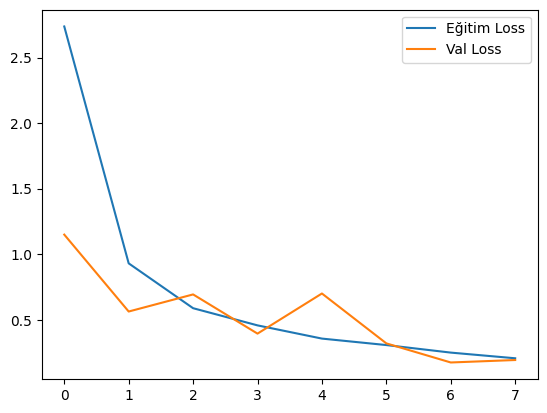

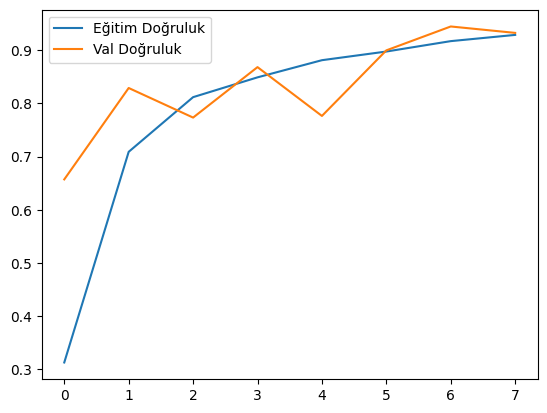

In [18]:
hist.history.keys()

mp.figure()
mp.plot(hist.history["loss"],label="Eğitim Loss")
mp.plot(hist.history["val_loss"],label="Val Loss")
mp.legend()

mp.figure()
mp.plot(hist.history["accuracy"],label="Eğitim Doğruluk")
mp.plot(hist.history["val_accuracy"],label="Val Doğruluk")
mp.legend()


score=model.evaluate(x2,y2,verbose=1)
print("Test loss:",score[0])
print("Test Doğruluk",score[1])


tahmin=model.predict(x_validation)
tahmin_class=np.argmax(tahmin,axis=1)




cm=confusion_matrix(y_validation, tahmin_class)